# Prepare of weather data

Data set contains Weather data for Kiel from January 1, 2012 to August 1, 2019.

    Datum : gives the date of the observed weather.
    Bewoelkung : describes the cloud coverage. Check this site for more info on the values.
    Temperature : gives the temperature in Celsius.
    Windgeschwindigkeit : gives the wind speed in meters per second.
    Wettercode : describes the type of weather. Check this site for more info on the values.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# load the weather dataset
weather_data = pd.read_csv('../bakery_sales_data/wetter.csv')

# change date format before merge to have same datatype on key
weather_data['Datum'] = pd.to_datetime(weather_data['Datum'])

# normalize range to base dataset
base_dateranges = pd.read_pickle('../exported_data/base_dateranges_data.pkl')

prepared_weather_data =  base_dateranges.merge(weather_data, on='Datum', how='left')

## Investigate date and find missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2223 entries, 0 to 2222
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                2223 non-null   datetime64[ns]
 1   Bewoelkung           2197 non-null   float64       
 2   Temperatur           2207 non-null   float64       
 3   Windgeschwindigkeit  2207 non-null   float64       
 4   Wettercode           1689 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 87.0 KB
Datum                    0
Bewoelkung              26
Temperatur              16
Windgeschwindigkeit     16
Wettercode             534
dtype: int64
Bewoelkung: [1, 2, 10, 2, 6, 2, 2, 1]
Temperatur: [1, 2, 2, 6, 2, 2, 1]
Windgeschwindigkeit: [1, 2, 2, 6, 2, 2, 1]
Wettercode: [1, 3, 1, 2, 3, 8, 1, 1, 4, 1, 1, 3, 3, 4, 1, 2, 1, 1, 3, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 3, 1, 2, 1, 2, 1, 3, 5, 

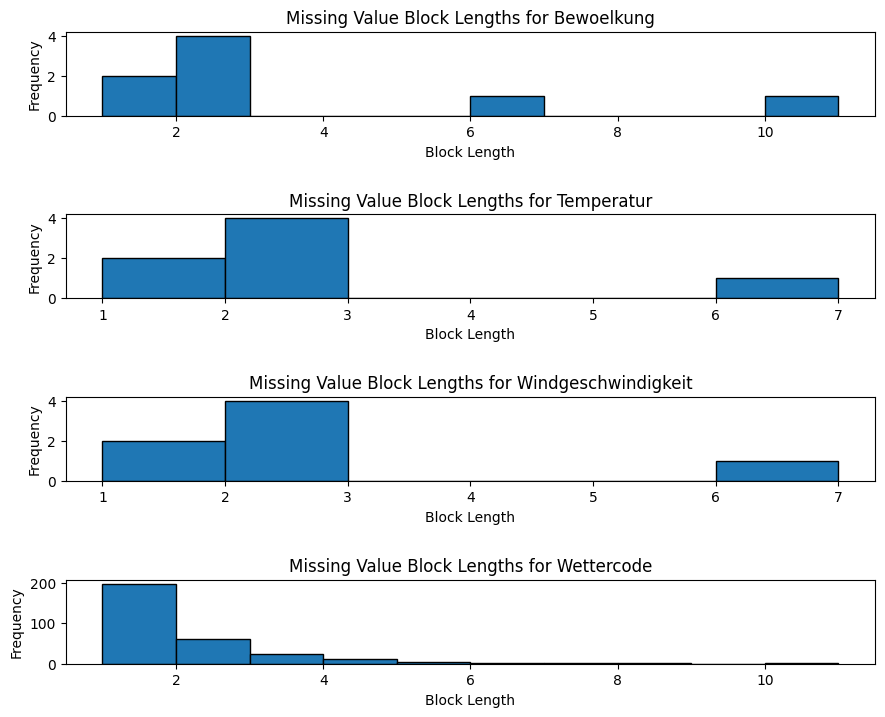

In [3]:
prepared_weather_data.info()

prepared_weather_data.head()

# show missing value count per column
missing_values = prepared_weather_data.isnull().sum()
print(missing_values)


# Show how much values in a row a missing to see what might be good stratgie to estimate the missing values

def find_missing_blocks(series):
    """Finds the lengths of contiguous missing value blocks in a series."""
    is_missing = series.isnull()
    block_lengths = []
    current_block_length = 0

    for missing in is_missing:
        if missing:
            current_block_length += 1
        elif current_block_length > 0:
            block_lengths.append(current_block_length)
            current_block_length = 0

    # Check if the last block reaches the end of the series
    if current_block_length > 0:
        block_lengths.append(current_block_length)

    return block_lengths

# calcuale blocks for column
missing_blocks = {}
for column in prepared_weather_data.columns[1:]:  # skip Datum 
    missing_blocks[column] = find_missing_blocks(prepared_weather_data[column])

# print result 
for column, blocks in missing_blocks.items():
    print(f"{column}: {blocks}")

# show in diagram
fig, ax = plt.subplots(len(missing_blocks), 1, figsize=(10, 8))
fig.tight_layout(pad=5.0)

for i, (column, blocks) in enumerate(missing_blocks.items()):
    ax[i].hist(blocks, bins=range(1, max(blocks)+2), edgecolor='black')
    ax[i].set_title(f"Missing Value Block Lengths for {column}")
    ax[i].set_xlabel('Block Length')
    ax[i].set_ylabel('Frequency')

plt.show()


## Use interpolation to add the missing values 

TODO: think if this is the best idea for weathe code data !?!

In [4]:
# Important to explicit set index, take care it remove the Datum column
prepared_weather_data.set_index('Datum', inplace=True)

prepared_weather_data.info()

# Linear interpolation based on the index (Datum)
prepared_weather_data_interpolated = prepared_weather_data.interpolate(method='time')

# ----- display results
# TODO: fix and improve to show if interpolation worked well

# Function to extract data before and after the gaps
#def extract_missing_sections(original_df, interpolated_df, context=2):
#    mask = original_df.isnull().any(axis=1)
#    missing_indices = original_df[mask].index
#    sections = []

#    for idx in missing_indices:
#        start_idx = max(0, original_df.index.get_loc(idx) - context)
#        end_idx = min(len(original_df), original_df.index.get_loc(idx) + context + 1)
#        sections.append(original_df.iloc[start_idx:end_idx])
#        sections.append(interpolated_df.iloc[start_idx:end_idx])
    
#    return sections

# Extract only the relevant sections
#sections = extract_missing_sections(prepared_weather_data, prepared_weather_data_interpolated)

# Den Index zurück in eine Spalte umwandeln für beide Dataframes
prepared_weather_data.reset_index(inplace=True)
prepared_weather_data_interpolated.reset_index(inplace=True)

# use the full dataframe as result 
prepared_weather_data = prepared_weather_data_interpolated


print("show if we have values for all missing data")
# calcuale blocks for column
missing_blocks = {}
for column in prepared_weather_data.columns[1:]:  # skip Datum 
    missing_blocks[column] = find_missing_blocks(prepared_weather_data[column])

# print result 
for column, blocks in missing_blocks.items():
    print(f"{column}: {blocks}")
    


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2223 entries, 2013-07-01 to 2019-08-01
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Bewoelkung           2197 non-null   float64
 1   Temperatur           2207 non-null   float64
 2   Windgeschwindigkeit  2207 non-null   float64
 3   Wettercode           1689 non-null   float64
dtypes: float64(4)
memory usage: 86.8 KB
Bewoelkung: []
Temperatur: []
Windgeschwindigkeit: []
Wettercode: []


## 

## Calculate and group more columns

- monthly_mean_temp_diff : The deviation of the daily temperature from the monthly mean temperature in degeree C 
- TODO: more to add!!!


In [5]:
# calculate and add mean temperature per month and deviation per day
# extract month and year
prepared_weather_data['Jahr_Monat'] = prepared_weather_data['Datum'].dt.to_period('M')

# calulate mean temperature per month
monthly_mean_temp = prepared_weather_data.groupby('Jahr_Monat')['Temperatur'].transform('mean')

# add the mean temperature as extra column
prepared_weather_data['monthly_mean_temp'] = monthly_mean_temp

# calculate the diff from month mean temp to temperature on day
prepared_weather_data['monthly_mean_temp_diff'] = prepared_weather_data['Temperatur'] - prepared_weather_data['monthly_mean_temp']

# store the prepared dataframe
prepared_weather_data.to_pickle('../exported_data/prepared_weather_data.pkl')